In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_dir ='/kaggle/input/mura-v11/MURA-v1.1'

def load_data():
    image_paths = []
    labels = []

    for folder in ['train', 'valid']:
        folder_path = os.path.join(base_dir, folder, 'XR_HAND')
        for patient_folder in os.listdir(folder_path):
            for study_folder in os.listdir(os.path.join(folder_path, patient_folder)):
                folder_name = study_folder.lower() 
                if 'positive' in folder_name:
                    label = 'positive' 
                elif 'negative' in folder_name:
                    label = 'negative'
                else:
                    continue 

                for image_file in os.listdir(os.path.join(folder_path, patient_folder, study_folder)):
                    image_path = os.path.join(folder_path, patient_folder, study_folder, image_file)
                    image_paths.append(image_path)
                    labels.append(label)

    return image_paths, labels

In [3]:
image_paths, labels = load_data()

In [4]:
# Create an array of shuffled indices
indices = np.arange(len(image_paths))

# Initialize lists for shuffled image paths and labels
shuffled_image_paths = []
shuffled_labels = []

# Function to check if an image file is valid
def is_valid_image(filename):
    try:
        with Image.open(filename) as img:
            return True
    except:
        return False

# Iterate through the shuffled indices
for index in indices:
    image_path = image_paths[index]
    label = labels[index]

    # Check if the image is valid
    if is_valid_image(image_path):
        image = Image.open(image_path)
        image = image.resize((224, 224), Image.BILINEAR)
        image = image.convert('RGB')

        image_array = np.array(image)

        shuffled_image_paths.append(image_array)
        shuffled_labels.append(label)

# Convert shuffled lists to arrays
X_shuffled = np.array(shuffled_image_paths)
Y_shuffled = np.array(shuffled_labels)

In [5]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_shuffled, Y_shuffled, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [6]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

In [7]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = True
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)



outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)



9406464/9406464 [==============================] - 0s 0us/step


In [10]:
from tensorflow.keras.optimizers import Adam, Adamax
lr=0.0001
model.compile(Adamax(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
epochs=100
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [12]:

# history = model.fit(
#     image_generator.flow(X_train, Y_train_encoded, batch_size=32),
#     validation_data=(X_val, Y_val_encoded),
#     epochs=10,
# )
history=model.fit(
    x=image_generator.flow(X_train, Y_train_encoded),  
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val_encoded),
)


Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7280
 validation loss of  0.7605 is below lowest loss, saving weights from epoch 1   as best weights
151/151 [==============================] - 85s 326ms/step - loss: 0.5600 - accuracy: 0.7280 - val_loss: 0.7605 - val_accuracy: 0.7317
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7670
 validation loss of  0.8201 is above lowest loss of  0.7605 keeping weights from epoch 1 as best weights
151/151 [==============================] - 47s 313ms/step - loss: 0.5117 - accuracy: 0.7670 - val_loss: 0.8201 - val_accuracy: 0.7317
Epoch 3/100
151/151 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.7903
 validation loss of  0.8839 is above lowest loss of  0.7605 keeping weights fr

 10


you entered  10  Training will continue to epoch  20
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


keeping current LR of 0.00010
151/151 [==============================] - 62s 412ms/step - loss: 0.3740 - accuracy: 0.8419 - val_loss: 0.6903 - val_accuracy: 0.7383
Epoch 11/100
151/151 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.8511
 validation loss of  0.7609 is above lowest loss of  0.6903 keeping weights from epoch 10 as best weights
151/151 [==============================] - 47s 309ms/step - loss: 0.3629 - accuracy: 0.8511 - val_loss: 0.7609 - val_accuracy: 0.7367
Epoch 12/100
151/151 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8494
 validation loss of  0.8317 is above lowest loss of  0.6903 keeping weights from epoch 10 as best weights
151/151 [==============================] - 46s 307ms/step - loss: 0.3511 - accuracy: 0.8494 - val_loss: 0.8317 - val_accuracy: 0.7350
Epoch 13/100
151/151 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.8517
 validation loss of  0.6671 is below lowest loss, saving weigh

 20


you entered  20  Training will continue to epoch  40
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


keeping current LR of 0.00010
151/151 [==============================] - 56s 372ms/step - loss: 0.2743 - accuracy: 0.8882 - val_loss: 0.4779 - val_accuracy: 0.8033
Epoch 21/100
151/151 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.8850
 validation loss of  0.4935 is above lowest loss of  0.4779 keeping weights from epoch 20 as best weights
151/151 [==============================] - 46s 306ms/step - loss: 0.2652 - accuracy: 0.8850 - val_loss: 0.4935 - val_accuracy: 0.8017
Epoch 22/100
151/151 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.8940
 validation loss of  0.5436 is above lowest loss of  0.4779 keeping weights from epoch 20 as best weights
151/151 [==============================] - 47s 308ms/step - loss: 0.2615 - accuracy: 0.8940 - val_loss: 0.5436 - val_accuracy: 0.8033
Epoch 23/100
151/151 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8969
 validation loss of  0.5678 is above lowest loss of  0.4779 ke

 20


you entered  20  Training will continue to epoch  60
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


keeping current LR of 0.00010
151/151 [==============================] - 72s 477ms/step - loss: 0.1617 - accuracy: 0.9363 - val_loss: 0.5934 - val_accuracy: 0.8333
Epoch 41/100
151/151 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9409
 validation loss of  0.5434 is above lowest loss of  0.4779 keeping weights from epoch 20 as best weights
151/151 [==============================] - 47s 309ms/step - loss: 0.1459 - accuracy: 0.9409 - val_loss: 0.5434 - val_accuracy: 0.8300
Epoch 42/100
151/151 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9450
 validation loss of  0.6744 is above lowest loss of  0.4779 keeping weights from epoch 20 as best weights
151/151 [==============================] - 47s 309ms/step - loss: 0.1439 - accuracy: 0.9450 - val_loss: 0.6744 - val_accuracy: 0.8300
Epoch 43/100
151/151 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9461
 validation loss of  0.6196 is above lowest loss of  0.4779 ke

 H


you entered  H  Training halted on epoch  60  due to user input

151/151 [==============================] - 555s 4s/step - loss: 0.1059 - accuracy: 0.9573 - val_loss: 0.7288 - val_accuracy: 0.8000
loading model with weights from epoch  20
training elapsed time was 0.0 hours, 56.0 minutes, 47.71 seconds)


In [13]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

19/19 [==============================] - 1s 49ms/step - loss: 0.5088 - accuracy: 0.7837
Test Accuracy: 78.37%


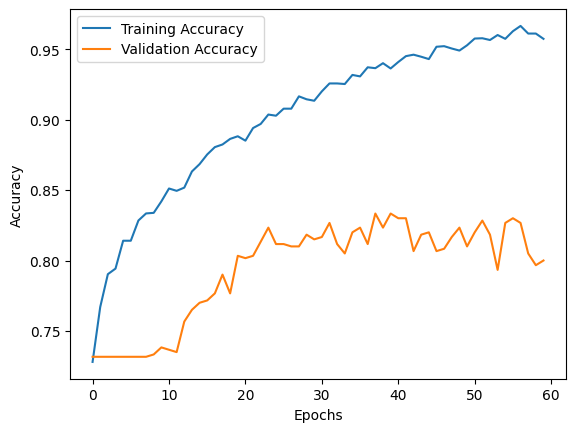

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

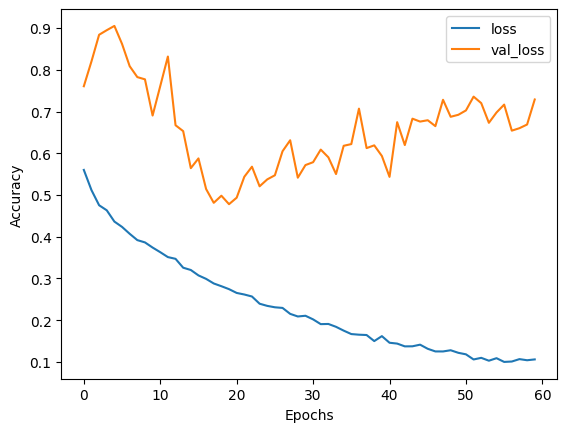

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


19/19 [==============================] - 1s 26ms/step


In [17]:
Y_test_original = label_encoder.inverse_transform(Y_test_encoded)
Y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [18]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_original, Y_pred_original)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.93      0.86       434
    positive       0.69      0.41      0.51       167

    accuracy                           0.78       601
   macro avg       0.74      0.67      0.69       601
weighted avg       0.77      0.78      0.76       601



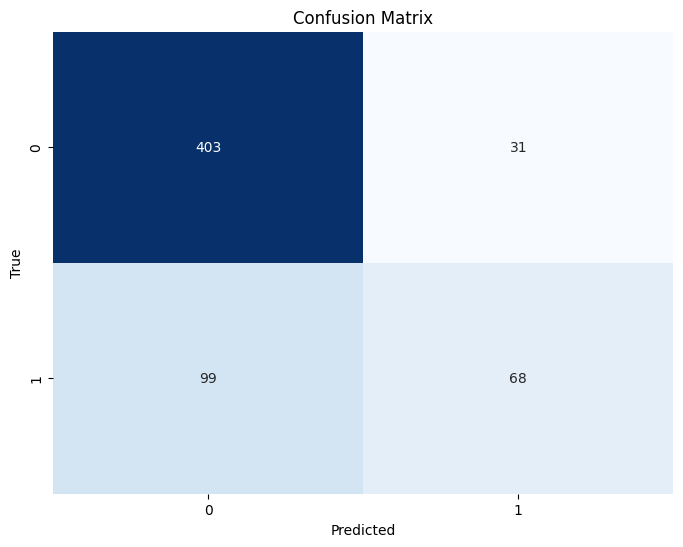

In [19]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(Y_test_original, Y_pred_original)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

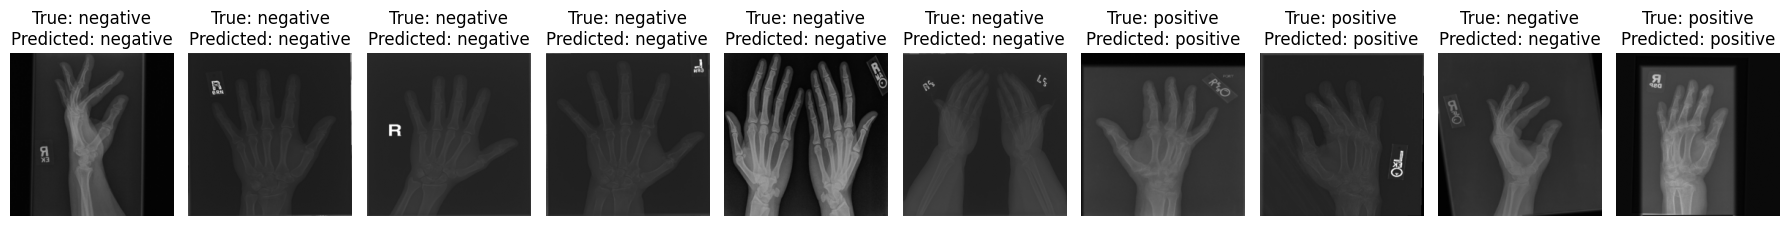

In [20]:
num_images_to_display = 10 
plt.figure(figsize=(18, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import tensorflow as tf
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    
    cam = cv2.resize(cam.numpy(), (img_array.shape[1], img_array.shape[2]))
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())  

    return cam 

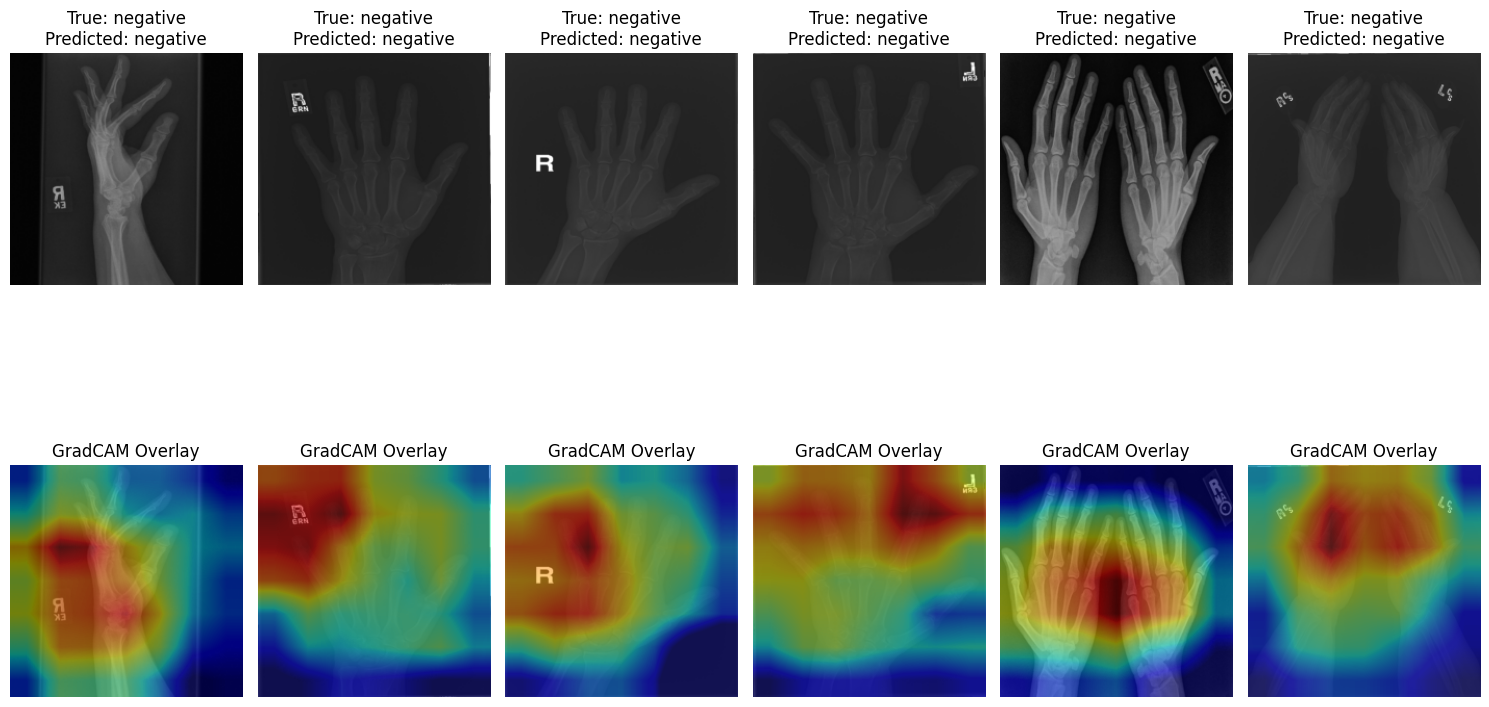

In [22]:
layer_name = 'Conv_1'
num_images_to_display = 6  

plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    img = X_test[i]

    img = (img * 255).astype(np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    img_array = preprocess_input(np.expand_dims(img, axis=0))  
    cam = compute_gradcam(model, img_array, layer_name)

    cam = (cam - cam.min()) / (cam.max() - cam.min())

    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(img, cmap='viridis') 
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')

    plt.subplot(2, num_images_to_display, i + num_images_to_display + 1)
    plt.imshow(img, cmap='viridis')  
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title('GradCAM Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
model_filename = "hand.h5"
model.save(model_filename)

print(f"Model saved as {model_filename}")

Model saved as hand.h5
